# KNN Classifier for Weather Classification

In [31]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

In [16]:
# Import dataset
df = pd.read_csv('weather_classification_data.csv')
df.shape

(13200, 11)

In [17]:
# Display the first 5 rows of the dataset
df.head()

,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location,Weather Type
0,14.0,73,9.5,82.0,partly cloudy,1010.82,2,Winter,3.5,inland,Rainy
1,39.0,96,8.5,71.0,partly cloudy,1011.43,7,Spring,10.0,inland,Cloudy
2,30.0,64,7.0,16.0,clear,1018.72,5,Spring,5.5,mountain,Sunny
3,38.0,83,1.5,82.0,clear,1026.25,7,Spring,1.0,coastal,Sunny
4,27.0,74,17.0,66.0,overcast,990.67,1,Winter,2.5,mountain,Rainy


## Preprocess Data

In [18]:
df.loc[0]

Temperature                      14.0
Humidity                           73
Wind Speed                        9.5
Precipitation (%)                82.0
Cloud Cover             partly cloudy
Atmospheric Pressure          1010.82
UV Index                            2
Season                         Winter
Visibility (km)                   3.5
Location                       inland
Weather Type                    Rainy
Name: 0, dtype: object

### Drop categorical features that will "explode" the feature count

In [19]:
X = df.drop(['Weather Type'], axis=1)
y = df['Weather Type']

X_number = X.select_dtypes(include='number') 
X_categorical = X.select_dtypes(exclude='number')

In [20]:
print('Unique values for each categorial feature:')
for k in X_categorical.columns:
    print(k, df[k].nunique())

Unique values for each categorial feature:
Cloud Cover 4
Season 4
Location 3


No need to drop any categorical features for having too many unique values.

### Standardization and One-Hot Encoding

In [21]:
X_number = (X_number - X_number.mean()) / X_number.std(ddof=0) #  Standardization
X_categorical = pd.get_dummies(X_categorical, dtype='int') # One-hot encoding

In [22]:
X = pd.concat([X_number,X_categorical],axis=1)
X.head()

,Temperature,Humidity,Wind Speed,Precipitation (%),Atmospheric Pressure,UV Index,Visibility (km),Cloud Cover_clear,Cloud Cover_cloudy,Cloud Cover_overcast,Cloud Cover_partly cloudy,Season_Autumn,Season_Spring,Season_Summer,Season_Winter,Location_coastal,Location_inland,Location_mountain
0,-0.294931,0.212404,-0.048086,0.887629,0.134203,-0.520104,-0.582231,0,0,0,1,0,0,0,1,0,1,0
1,1.143035,1.351385,-0.192836,0.543291,0.150602,0.776424,1.345768,0,0,0,1,0,1,0,0,0,1,0
2,0.625367,-0.233285,-0.409962,-1.178401,0.346579,0.257813,0.010999,1,0,0,0,0,1,0,0,0,0,1
3,1.085516,0.707613,-1.206089,0.887629,0.549008,0.776424,-1.323769,1,0,0,0,0,1,0,0,1,0,0
4,0.452811,0.261924,1.037543,0.386773,-0.407490,-0.779410,-0.878846,0,0,1,0,0,0,0,1,0,0,1


In [23]:
df = pd.concat([X,y], axis=1)

### Drop irrelevant features

Based on the plots of features against the weather type, all features are relevant to classification of weather type (see PrelimWork.ipynb). The only notable candidate feature to drop either humidity or precipitation, which have a relatively high correlation.

In [30]:
df['Humidity'].corr(df['Precipitation (%)'])

np.float64(0.6386309686155685)

We decided not that the correlation value of 0.64 is not high enough to warrant dropping either feature. In fact, the differences between the features may contribute to the effectiveness of the model.

## KNN Classifier Model

In [24]:
# Train/Test Split
(df_train,df_test) = train_test_split(df, train_size=0.8, random_state=0)

In [25]:
# Create X_train, X_test, y_train, y_test
X_train = df_train.drop(['Weather Type'], axis=1)
X_test = df_test.drop(['Weather Type'], axis=1)

y_train = df_train['Weather Type']
y_test = df_test['Weather Type']

In [32]:
# Create arrays to store k and respective error values
K = []
err_train = []
err_test = []

# Test K=1..200
for k in np.arange(100)+1:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    K.append(k)
    err_train.append(1 - knn.score(X_train, y_train))
    err_test.append(1 - knn.score(X_test, y_test))

In [33]:
# Store results in dataframe
results = pd.DataFrame()
results['K'] = K
results['train error'] = err_train
results['test error'] = err_test
results.head()

,K,train error,test error
0,1,0.000000,0.106818
1,2,0.053598,0.105303
2,3,0.063447,0.099242
3,4,0.069318,0.100000
4,5,0.073485,0.095833


<Axes: xlabel='K'>

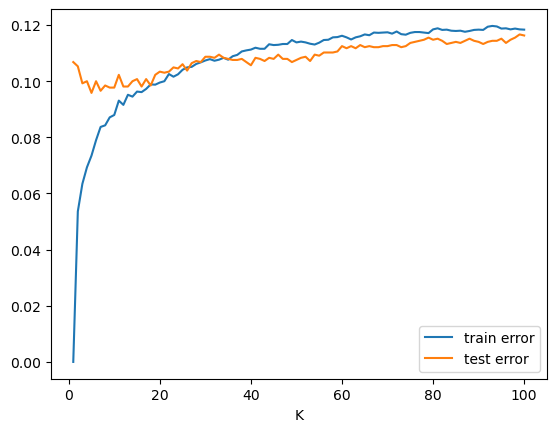

In [34]:
# Plot results
ax1 = results.plot.line(x='K',y='train error')
results.plot.line(x='K',y='test error',ax=ax1)

In [36]:
# Find stats for smallest test error
ix = results['test error'].idxmin()
results.iloc[ix]

K              5.000000
train error    0.073485
test error     0.095833
Name: 4, dtype: float64

In [37]:
K = 4
knn = KNeighborsClassifier(n_neighbors = K)
knn.fit(X_train, y_train)

accuracy_train = knn.score(X_train, y_train)
accuracy_test = knn.score(X_test, y_test)

print('Training Accuracy', accuracy_train)
print('Testing Accuracy', accuracy_test)

Training Accuracy 0.9306818181818182
Testing Accuracy 0.9
